In [ ]:
import matplotlib.pyplot as plt


?
load data


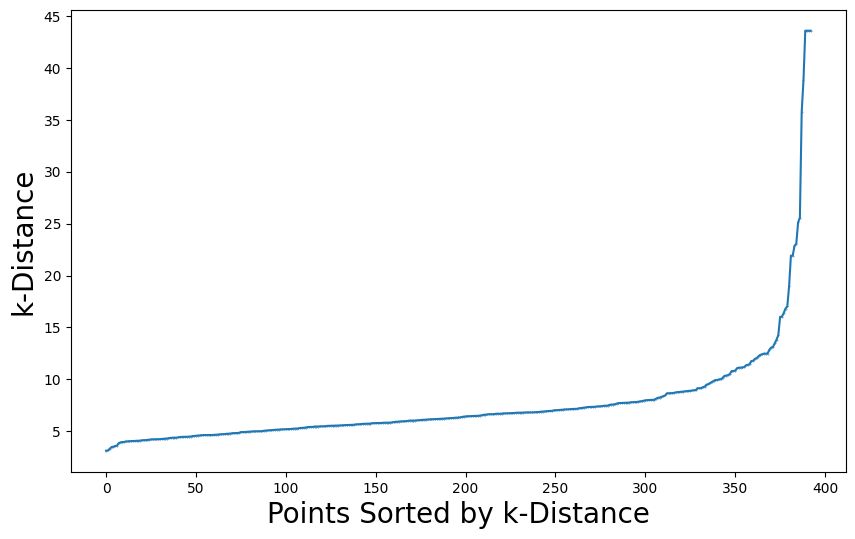

[ 9.54431481  9.74988336  9.63978169  9.93616679  9.84425543  9.9376732
 21.90995973 21.90995973]


In [2]:
from utils import *
import numpy as np
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.utils import check_random_state
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
import matplotlib.pyplot as plt

print('?')


def calculate_derivative(distances):
    return np.gradient(np.gradient(distances))


def multiple_index_selection(data, eps_list, start=None, end=None, step=None):
    sc_list = []
    dbs_list = []
    chs_list = []
    final_index_list = []
    try:
        if eps_list is None:
            for eps in np.arange(start, end, step):
                dbscan = DBSCAN(min_samples=4, eps=eps)
                labels = dbscan.fit_predict(data)
                sc_list.append(silhouette_score(data, labels))
                dbs_list.append(davies_bouldin_score(data, labels))
                chs_list.append(calinski_harabasz_score(data, labels))
                final_index_list.append(sc_list[-1] * chs_list[-1] / dbs_list[-1])
        else:
            for eps in eps_list:
                dbscan = DBSCAN(min_samples=4, eps=eps)
                labels = dbscan.fit_predict(data)
                sc_list.append(silhouette_score(data, labels))
                dbs_list.append(davies_bouldin_score(data, labels))
                chs_list.append(calinski_harabasz_score(data, labels))
                final_index_list.append(sc_list[-1] * chs_list[-1] / dbs_list[-1])
    except:
        pass
    # 选取final_index_list最大的eps
    eps_index = np.argsort(final_index_list)
    max_score = max(final_index_list)
    temp_eps = eps_index[final_index_list==max_score]
    print(eps_list[temp_eps])
    min_eps_index = min(temp_eps)
    selected_eps = eps_list[min_eps_index]
    # return selected_eps
    return sc_list, dbs_list, chs_list

dataset_name = 'credit'
RUNS = 10
RANDOM_STATE = 42
MAX_INT = np.iinfo(np.int32).max
seeds = check_random_state(RANDOM_STATE).randint(MAX_INT, size=RUNS)
test_size = 0.2
STEP = 0.01
print('load data')
X_train, y_train, X_test, y_test = load_dataset_by_name(
    name=dataset_name, test_size=test_size, randon_state=RANDOM_STATE
)
X_min_train = X_train[y_train == 1]

nbr_k = 7
nbrs = NearestNeighbors(n_neighbors=nbr_k).fit(X_min_train)

# 计算每个点的第k个最近邻距离
distances, indices = nbrs.kneighbors(X_min_train)

# 对距离进行排序
distances = np.sort(distances, axis=0)

# 计算距离的增长率
growth_rate = np.diff(distances[:, nbr_k - 1])

# 寻找距离增长幅度减缓的位置（拐点）
turning_point_index = np.argmax(growth_rate)

# 绘制K距离图
plt.figure(figsize=(10, 6))
plt.plot(distances[:, nbr_k - 1], marker='o', markersize=0.3)
# plt.scatter(turning_point_index, distances[turning_point_index, nbr_k - 1], color='red', label='Turning Point')
# plt.title(f'K-distance Graph with Turning Point (k={nbr_k})')
plt.xlabel('Points Sorted by k-Distance', fontsize=20)
plt.ylabel('k-Distance', fontsize=20)
# plt.legend()
plt.show()

# 输出拐点的位置和距离
# print(f'Turning Point Index: {turning_point_index}')
# print(f'Turning Point Distance: {distances[turning_point_index, nbr_k - 1]}')

percentage2keep = 1
endpoint = 0.9
# brute_list = distances[:, nbr_k - 1][int(len(distances) * (1 - percentage2keep)): int(len(distances) * endpoint)]
# print(brute_list)
brute_list = distances[:, nbr_k - 1]

sc_list,  dbs_list, chs_list= multiple_index_selection(X_min_train, eps_list=brute_list)

# print(selected_eps)

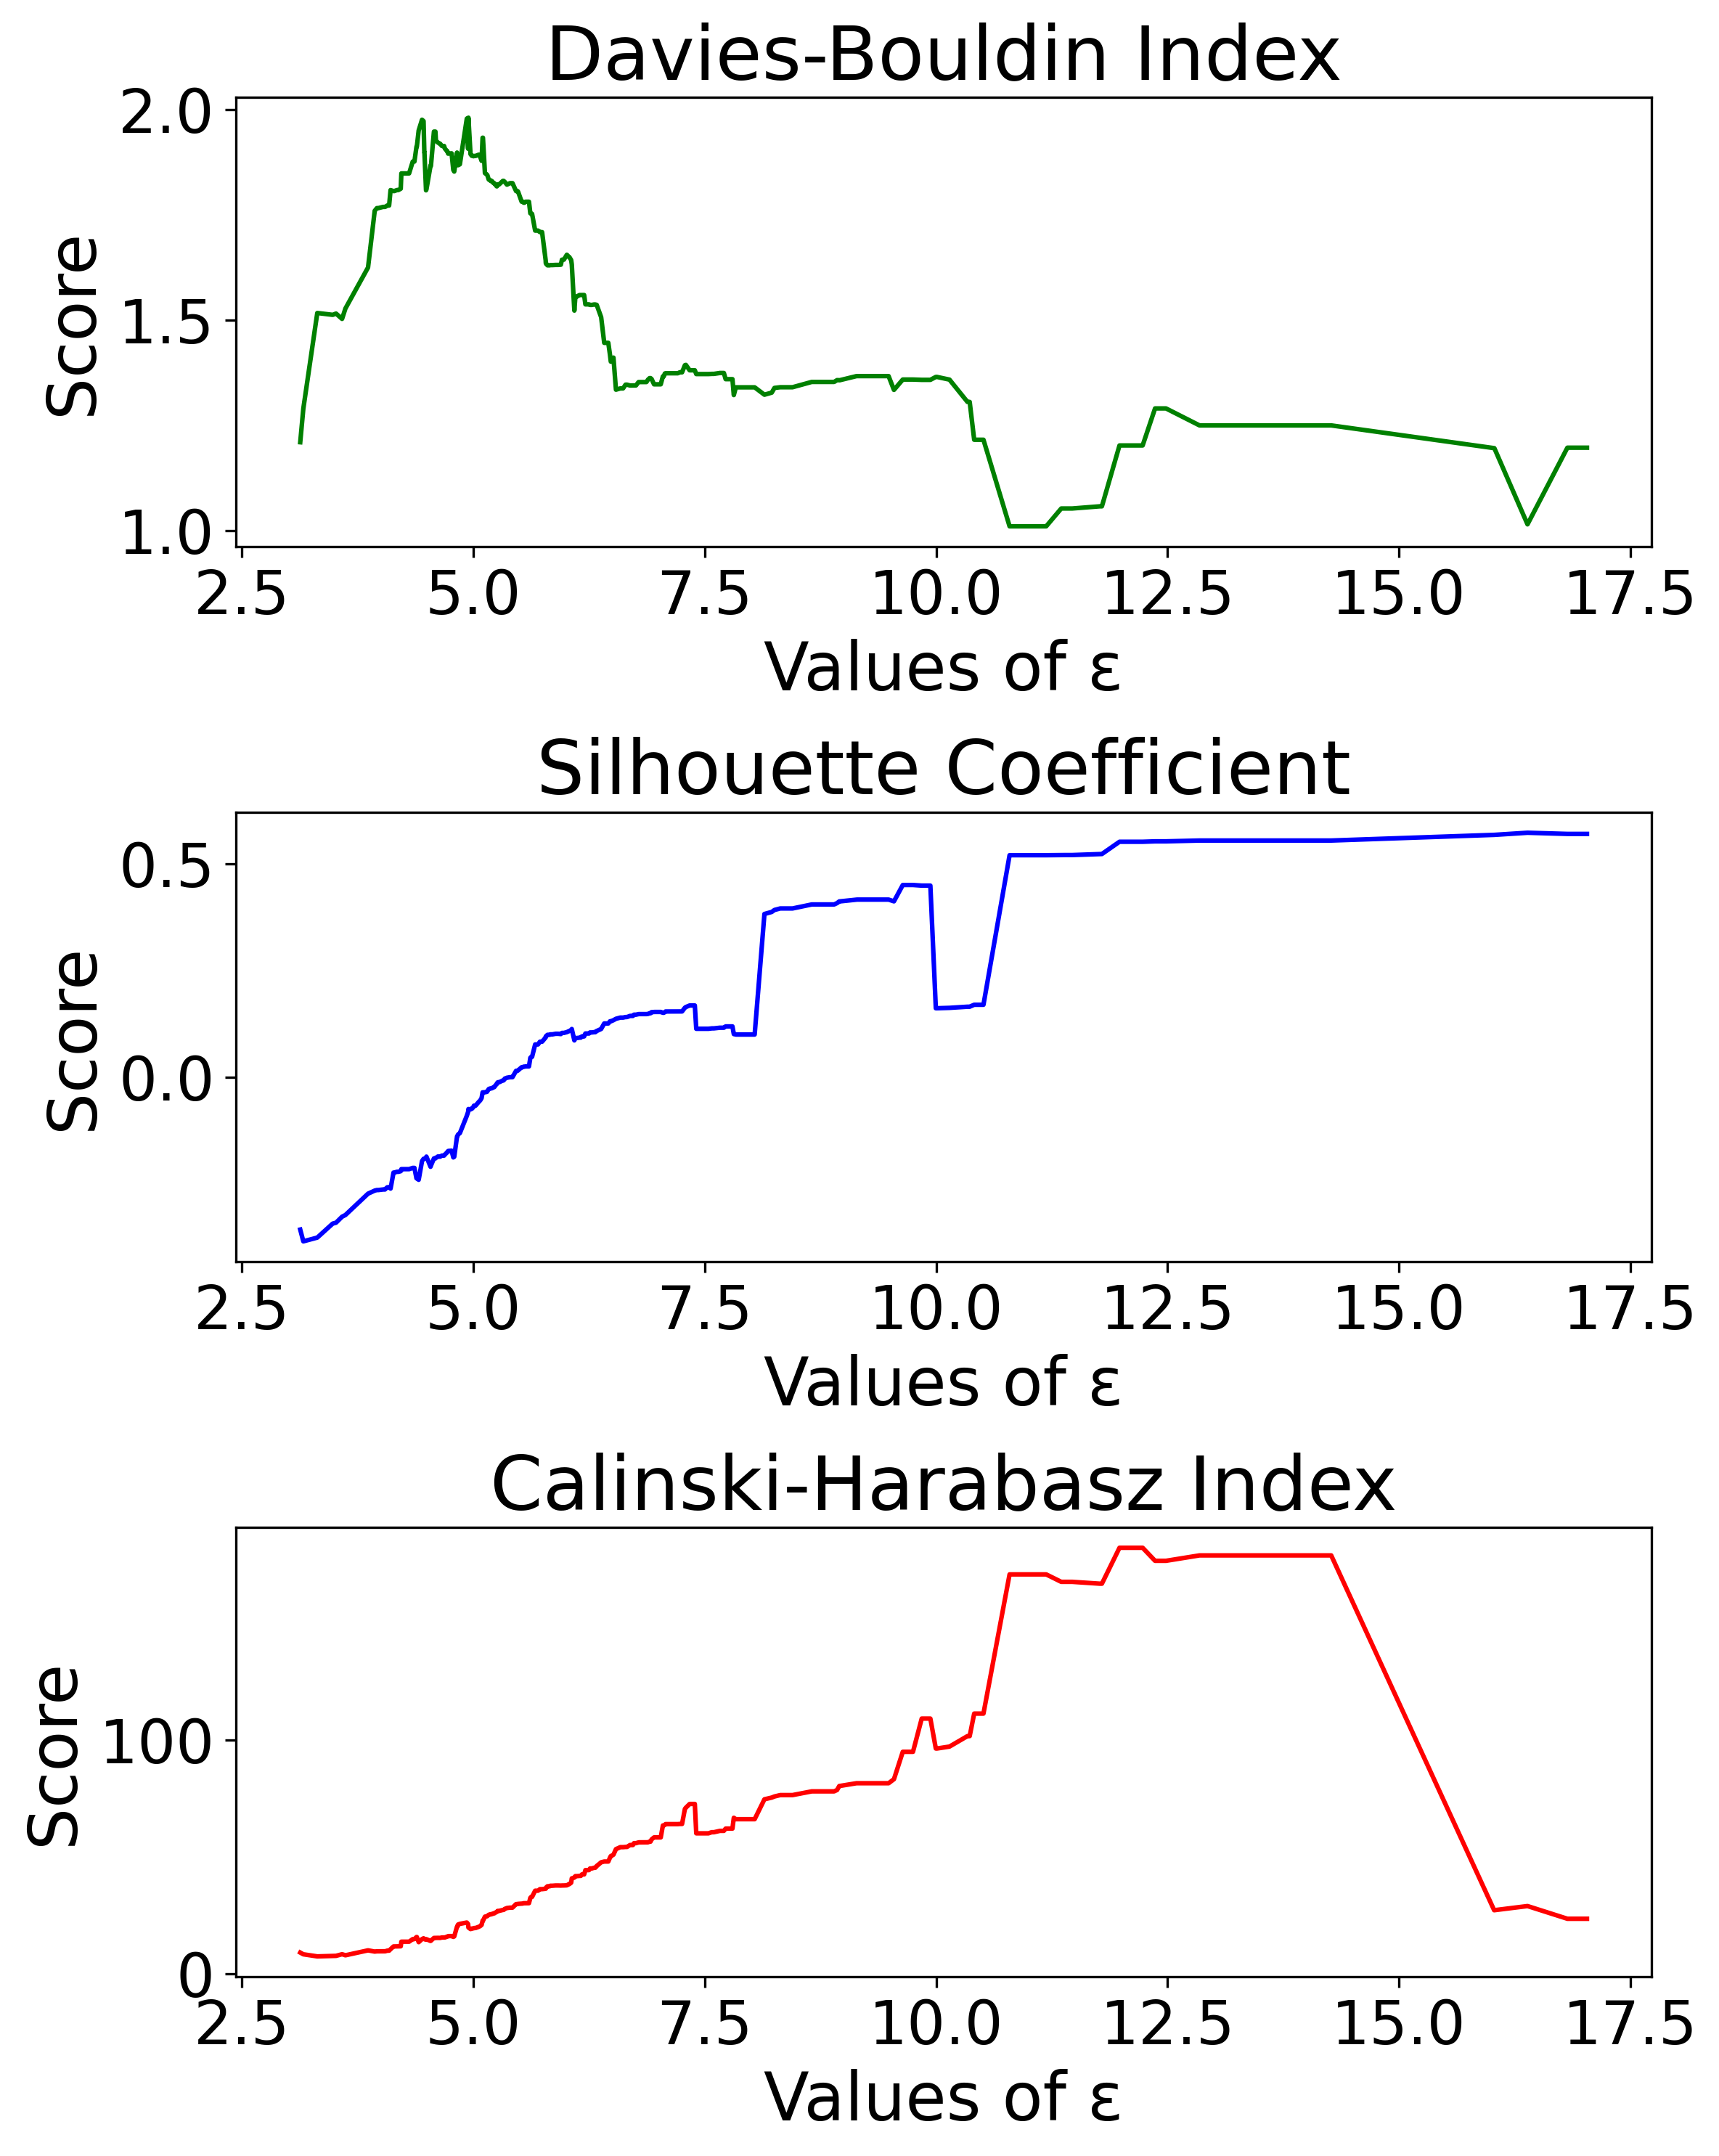

In [4]:
sc_list, dbs_list, chs_list = sc_list[0:380], dbs_list[0:380], chs_list[0:380]

# 假设你有一些X轴的值（这里假设为索引）
# x_values = range(1, len(sc_list) + 1)
x_values = brute_list[0:380]
# 创建三个图表和轴
fig, (ax2, ax1, ax3) = plt.subplots(3, 1, figsize=(8, 10), dpi=300)

# 绘制第二个图表（Davies-Bouldin Score）
ax2.plot(x_values, dbs_list, label='Davies-Bouldin Index', color='green')
ax2.set_title('Davies-Bouldin Index', fontsize=25)
ax2.set_xlabel('Values of ε', fontsize=22)
ax2.set_ylabel('Score', fontsize=22)
ax2.tick_params(axis='x', labelsize=20)
ax2.tick_params(axis='y', labelsize=20)
# ax2.legend(fontsize=12, loc='lower right')

# 绘制第一个图表（Silhouette Coefficient）
ax1.plot(x_values, sc_list, label='Silhouette Coefficient', color='blue')
ax1.set_title('Silhouette Coefficient', fontsize=25)
ax1.set_xlabel('Values of ε', fontsize=22)
ax1.set_ylabel('Score', fontsize=22)
ax1.tick_params(axis='x', labelsize=20)
ax1.tick_params(axis='y', labelsize=20)
# ax1.legend(fontsize=12, loc='lower right')



# 绘制第三个图表（Calinski-Harabasz Index）
ax3.plot(x_values, chs_list, label='Calinski-Harabasz Index', color='red')
ax3.set_title('Calinski-Harabasz Index', fontsize=25)
ax3.set_xlabel('Values of ε', fontsize=22)
ax3.set_ylabel('Score', fontsize=22)
ax3.tick_params(axis='x', labelsize=20)
ax3.tick_params(axis='y', labelsize=20)

# ax3.legend(fontsize=12, loc='lower right')

# 调整布局
plt.tight_layout()

# 保存每个图表
plt.savefig('cluster-metrics.pdf', bbox_inches='tight')

# 显示图表
plt.show()



